In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from theano import shared
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-darkgrid')

In [4]:
import pymc3.sampling_jax

/usr/local/lib/python3.8/dist-packages/pymc3/sampling_jax.py:22: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Simple linear regression

In [5]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

# we can center the data
#x = x - x.mean()
# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

<ipython-input-6-5642537206ee>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


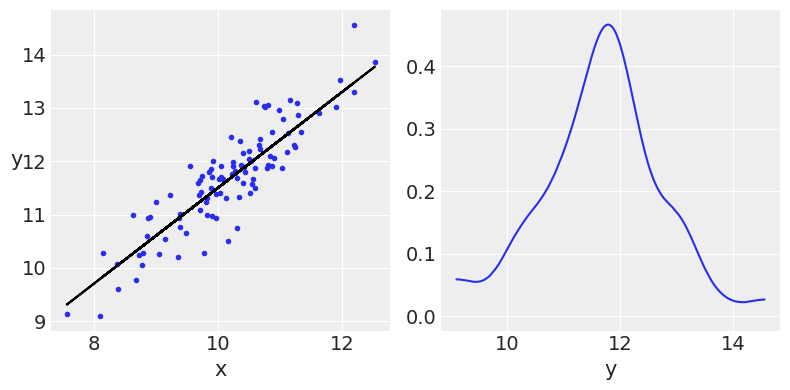

In [6]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()
plt.savefig('B11197_03_02.png', dpi=300)

In [9]:
%%time
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_g = pm.sampling_jax.sample_numpyro_nuts(2000, tune=1000)

Compiling...
Compilation + sampling time =  0 days 00:00:07.171288
CPU times: user 7.92 s, sys: 35.9 ms, total: 7.95 s
Wall time: 7.58 s


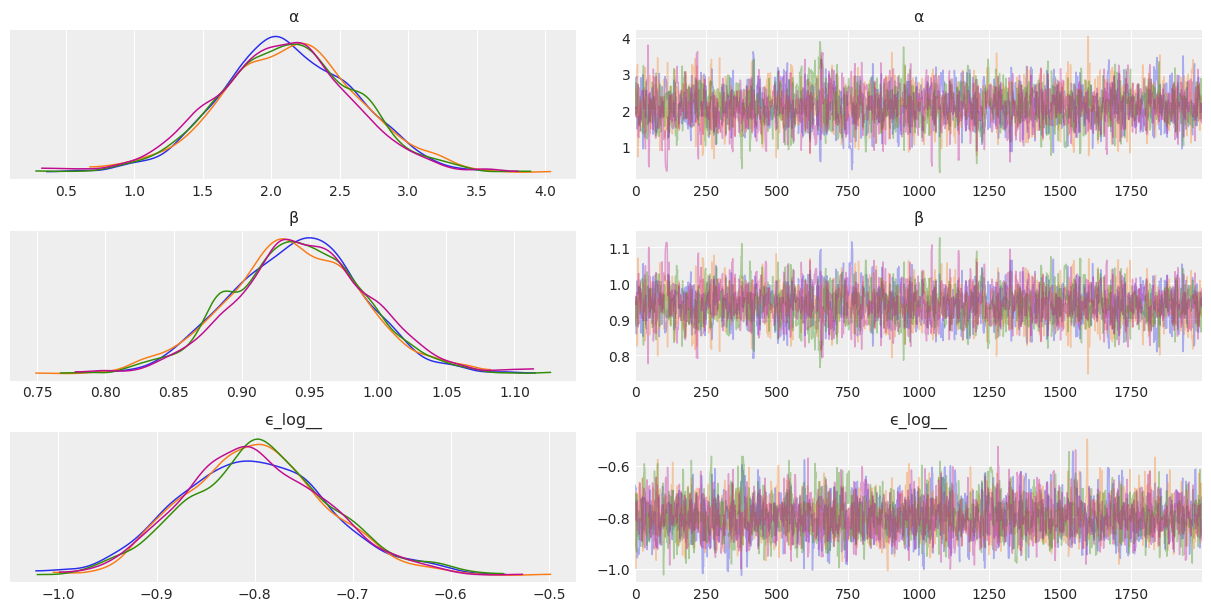

In [11]:
az.plot_trace(trace_g, var_names=['α', 'β', 'ϵ_log__'])
plt.savefig('B11197_03_03.png', dpi=300)

### Modyfing the data before running the models

/usr/local/lib/python3.8/dist-packages/arviz/plots/pairplot.py:180: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


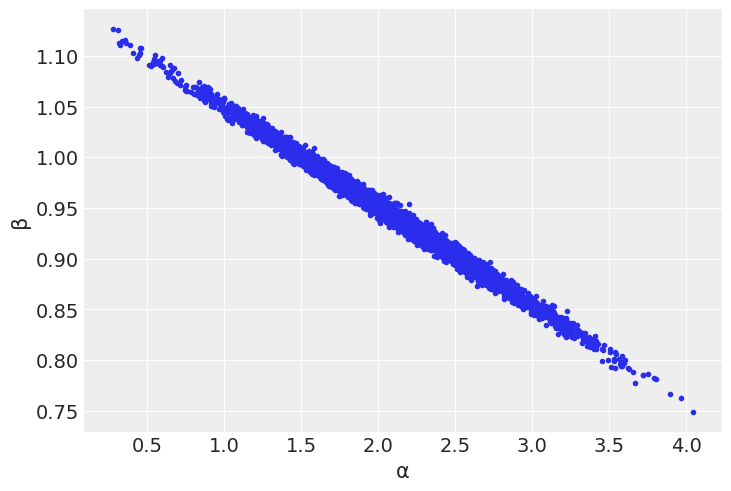

In [12]:
az.plot_pair(trace_g, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1})
plt.savefig('B11197_03_04_jax.png', dpi=300)

### interpreting the posterior

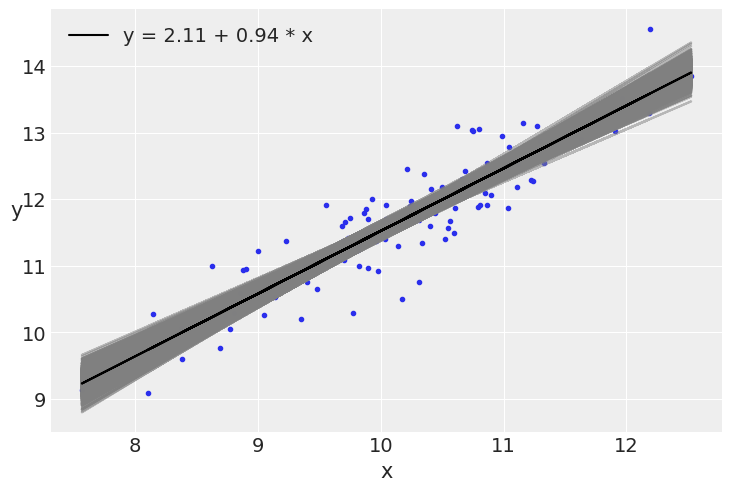

In [15]:
plt.plot(x, y, 'C0.')

trace_g_dict = trace_g.to_dict()['posterior']

alpha_m = trace_g_dict['α'].mean()
beta_m = trace_g_dict['β'].mean()

draws = range(0, len(trace_g_dict['α']), 10)
plt.plot(x, trace_g_dict['α'][draws] + trace_g_dict['β'][draws]
         * x[:, np.newaxis], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()
plt.savefig('B11197_03_05.png', dpi=300)

In [17]:
pm.summary(trace_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,2.112,0.502,1.186,3.085,0.012,0.008,1865.0,1865.0,1871.0,2427.0,1.0
β,0.941,0.049,0.842,1.028,0.001,0.001,1867.0,1867.0,1882.0,2397.0,1.0
ϵ_log__,-0.798,0.074,-0.944,-0.666,0.001,0.001,2739.0,2739.0,2768.0,2440.0,1.0


In [18]:
# plt.plot(x, alpha_m + beta_m * x, c='k',
#          label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

# sig = az.plot_hpd(x, trace_g['μ'], credible_interval=0.98, color='k')

# plt.xlabel('x')
# plt.ylabel('y', rotation=0)
# plt.legend()
# plt.savefig('B11197_03_06.png', dpi=300)

In [19]:
ppc = pm.sample_posterior_predictive(trace_g, samples=2000, model=model_g)

/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:1680: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/usr/local/lib/python3.8/dist-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


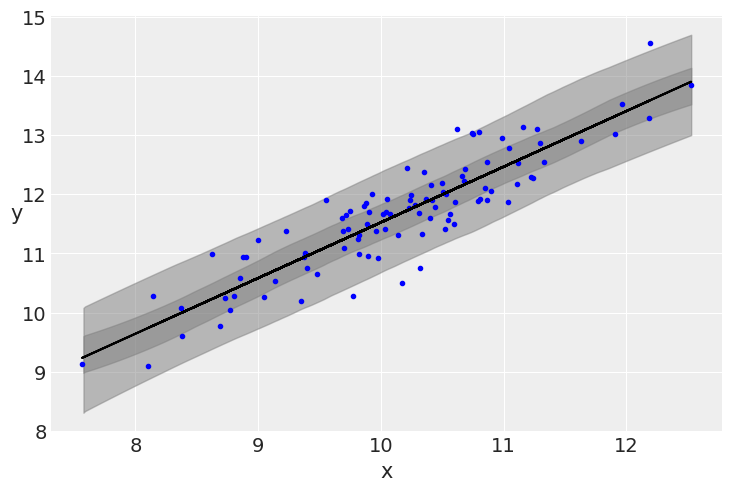

In [26]:
fig, ax = plt.subplots()

ax.plot(x, y, 'b.')
ax.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hpd(x, ppc['y_pred'], credible_interval=0.5, color='gray',ax=ax)
az.plot_hpd(x, ppc['y_pred'], color='gray',ax=ax)

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_07.png', dpi=300)

In [27]:
az.r2_score(y, ppc['y_pred'])

r2        0.788703
r2_std    0.004739
dtype: float64

### The multivariate normal distribution 
Actually the bivariate

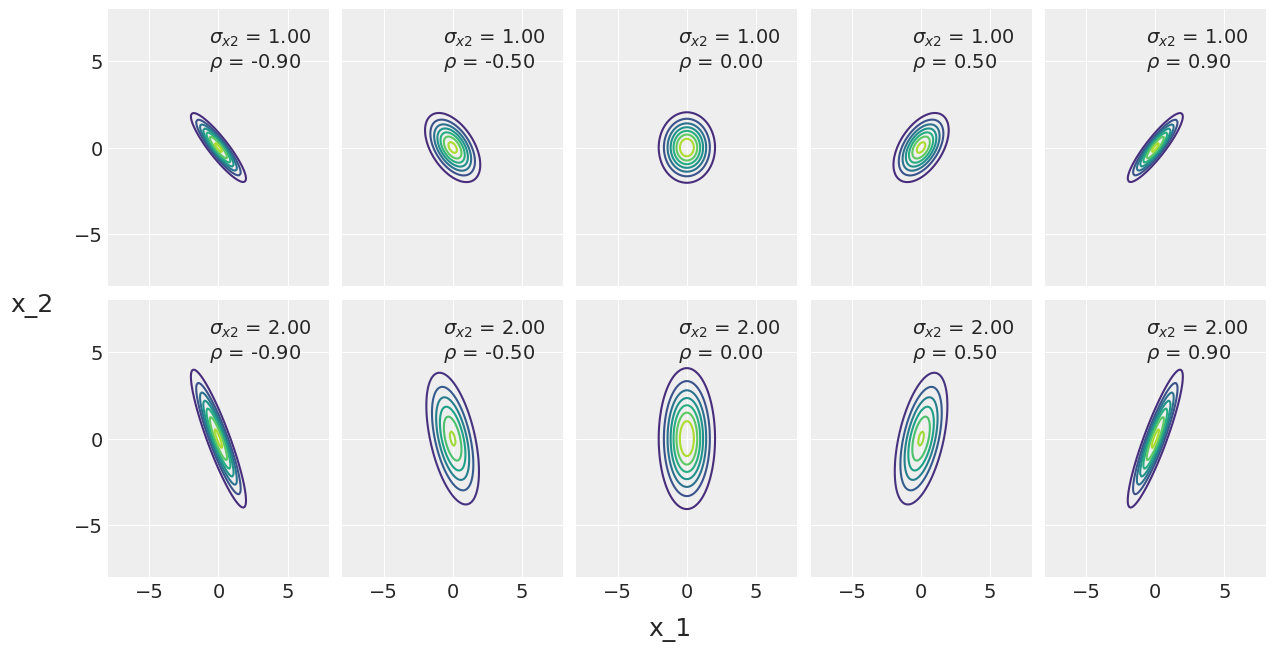

In [28]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.90, -0.5, 0, 0.5, 0.90]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k
pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos),
                     sharex=True, sharey=True, figsize=(12, 6),
                     constrained_layout=True)
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
               [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i, j].contour(k, l, rv.pdf(pos))
        ax[i, j].set_xlim(-8, 8)
        ax[i, j].set_ylim(-8, 8)
        ax[i, j].set_yticks([-5, 0, 5])
        ax[i, j].plot(0, 0,
                      label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
        ax[i, j].legend()
f.text(0.5, -0.05, 'x_1', ha='center', fontsize=18)
f.text(-0.05, 0.5, 'x_2', va='center', fontsize=18, rotation=0)
plt.savefig('B11197_03_08.png', dpi=300)

In [63]:
%%time
data = np.stack((x, y)).T
with pm.Model() as pearson_model:

    μ = pm.Normal('μ', mu=data.mean(0), sd=10, shape=2)

    σ_1 = pm.HalfNormal('σ_1', 10)
    σ_2 = pm.HalfNormal('σ_2', 10)
    ρ = pm.Uniform('ρ', -1., 1.)
    r2 = pm.Deterministic('r2', ρ**2)

    cov = pm.math.stack(([σ_1**2, σ_1*σ_2*ρ],
                         [σ_1*σ_2*ρ, σ_2**2]))

    y_pred = pm.MvNormal('y_pred', mu=μ, cov=cov, observed=data)

    trace_p = pm.sampling_jax.sample_numpyro_nuts(1000)

Compiling...


/usr/local/lib/python3.8/dist-packages/jax/interpreters/xla.py:666: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:09.152337
CPU times: user 11.7 s, sys: 2.02 s, total: 13.7 s
Wall time: 10.1 s


array([[<AxesSubplot:title={'center':'ρ_interval__'}>,
        <AxesSubplot:title={'center':'ρ_interval__'}>]], dtype=object)

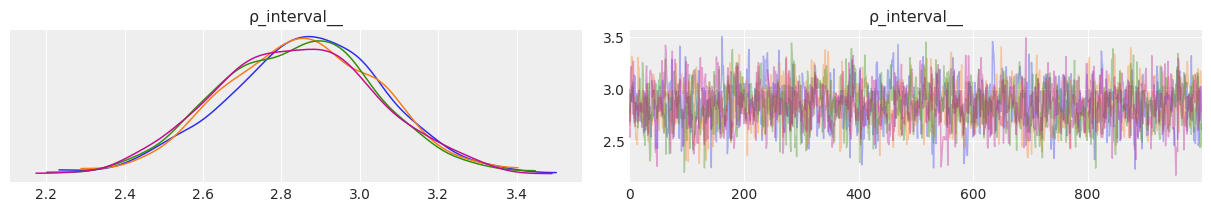

In [57]:
az.plot_trace(trace_p, var_names=['ρ_interval__'])
# plt.savefig('B11197_03_9.png', dpi=300)

In [66]:
ppc = pm.sample_posterior_predictive(trace_p, samples=2000, var_names=["r2", "y_pred"], model=pearson_model)
ppc

/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:1680: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


{'r2': array([0.77366817, 0.76126494, 0.81056573, ..., 0.84539244, 0.8284361 ,
        0.83066896]),
 'y_pred': array([[ 8.27789243,  8.90546983],
        [10.40517789, 13.02580753],
        [10.53478928, 12.13709262],
        ...,
        [ 8.3519948 ,  9.86544655],
        [10.43962756, 12.74152171],
        [12.0308735 , 13.74345375]])}

In [68]:
ppc['r2'].shape

(2000,)

# from here

## Robust linear regression

In [71]:
ans = pd.read_csv('../data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

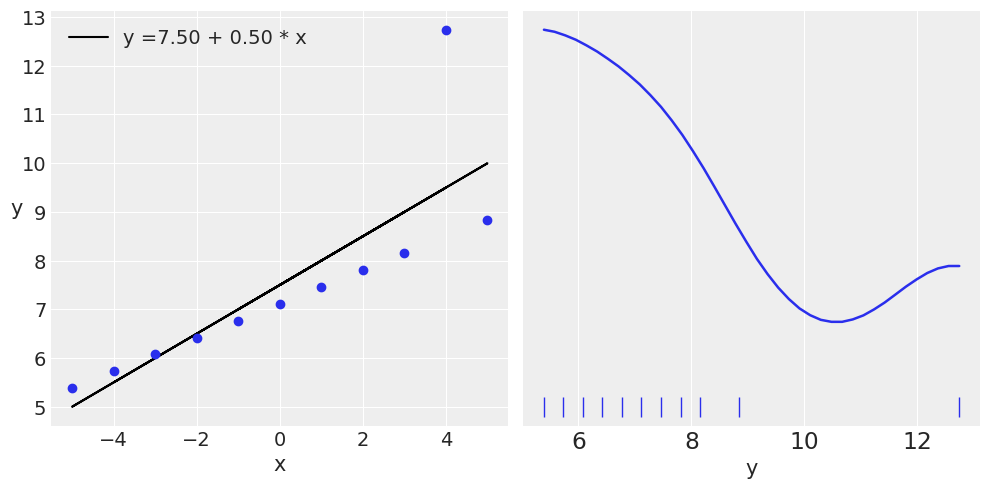

In [18]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()
plt.savefig('B11197_03_10.png', dpi=300)

In [19]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                         sd=ϵ, nu=ν, observed=y_3)

    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_, ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:06<00:00, 739.17draws/s] 
The acceptance probability does not match the target. It is 0.8814466002199226, but should be close to 0.8. Try to increase the number of tuning steps.


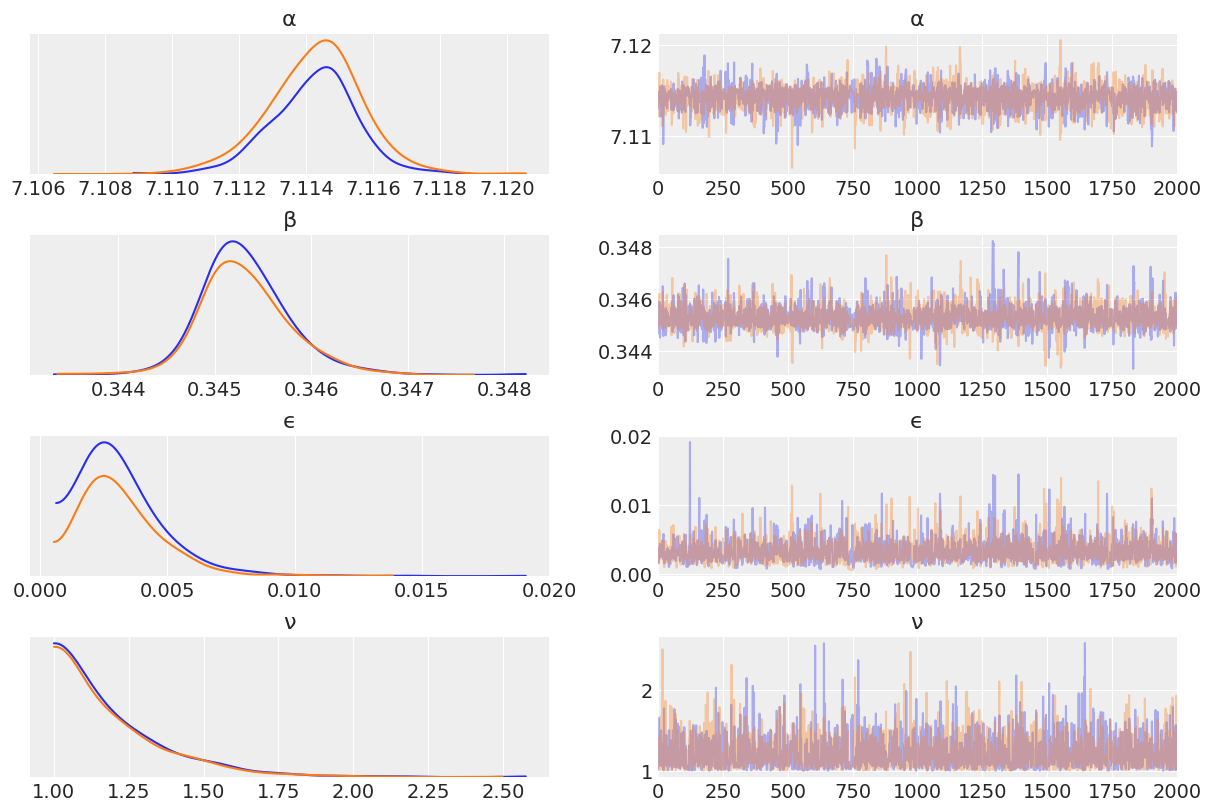

In [20]:
varnames = ['α', 'β', 'ϵ', 'ν']
az.plot_trace(trace_t, var_names=varnames);

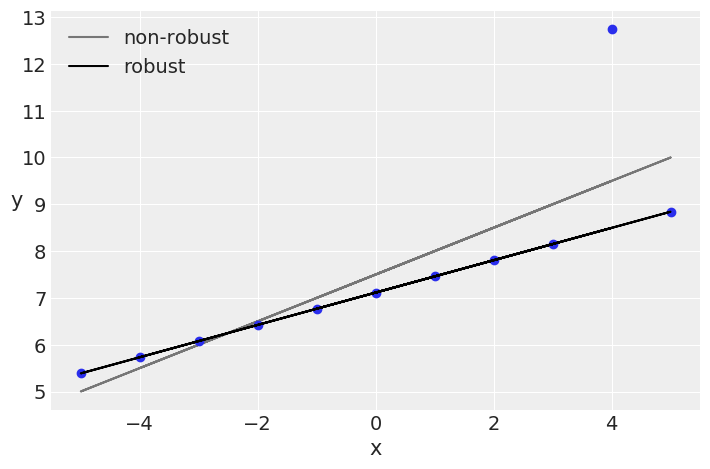

In [21]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = trace_t['α'].mean()
beta_m = trace_t['β'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

plt.savefig('B11197_03_11.png', dpi=300)

In [22]:
az.summary(trace_t, var_names=varnames)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,7.11,0.0,0.0,7.11,7.12,2402.0,1.0
β,0.35,0.0,0.0,0.34,0.35,1947.0,1.0
ϵ,0.00,0.0,0.0,0.00,0.01,2012.0,1.0
ν,1.20,0.2,0.0,1.00,1.56,3359.0,1.0


In [23]:
ppc = pm.sample_posterior_predictive(trace_t, samples=200, model=model_t, random_seed=2)

100%|██████████| 200/200 [00:00<00:00, 1345.40it/s]


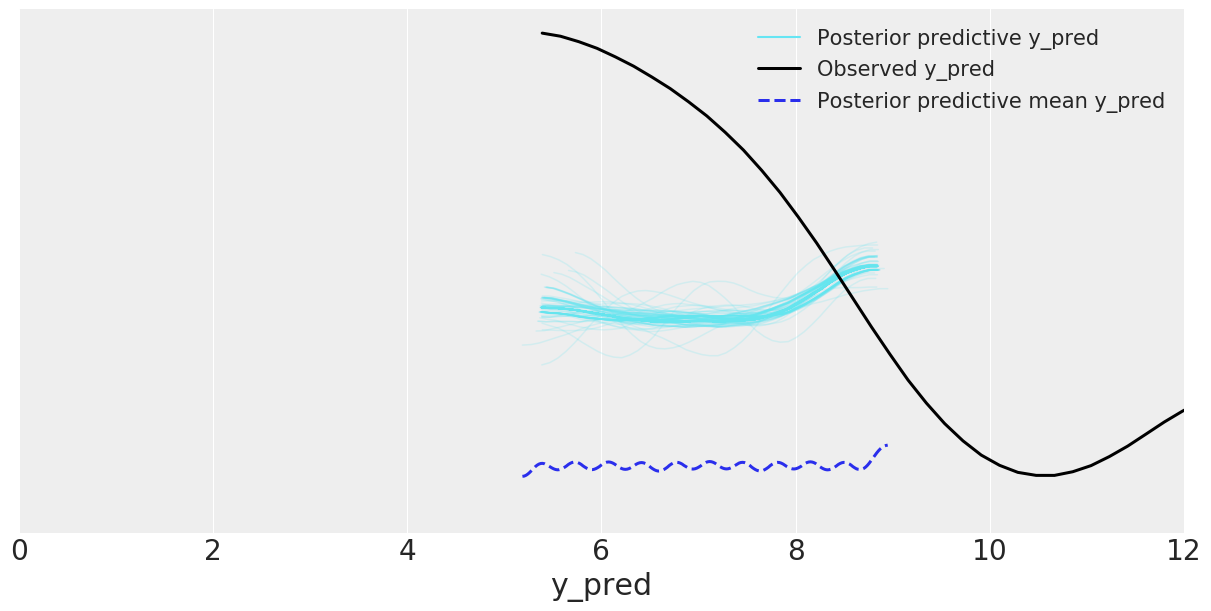

In [24]:
data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
plt.xlim(0, 12)
plt.savefig('B11197_03_12.png', dpi=300)

## Hierarchical linear regression

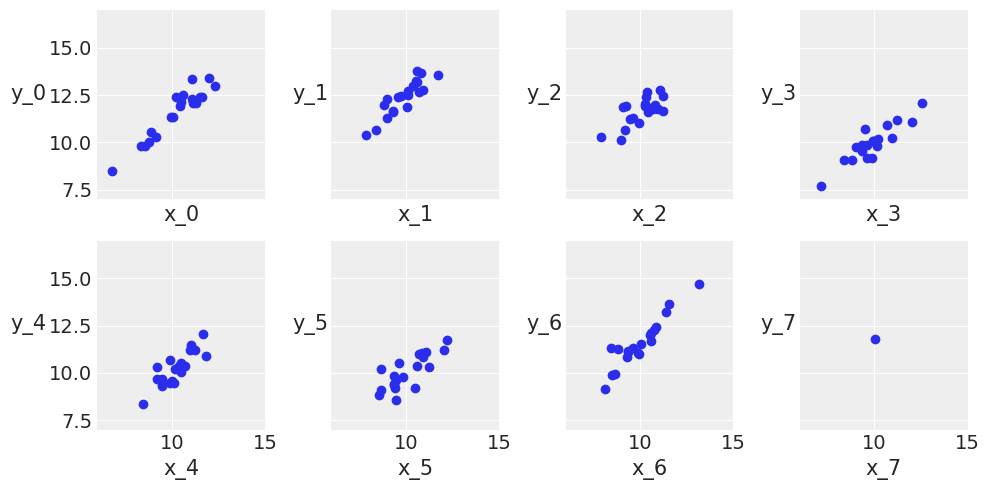

In [25]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B11197_03_13.png', dpi=300)

In [26]:
x_centered = x_m - x_m.mean()

In [27]:
with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())

    trace_up = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α_tmp]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 886.26draws/s] 


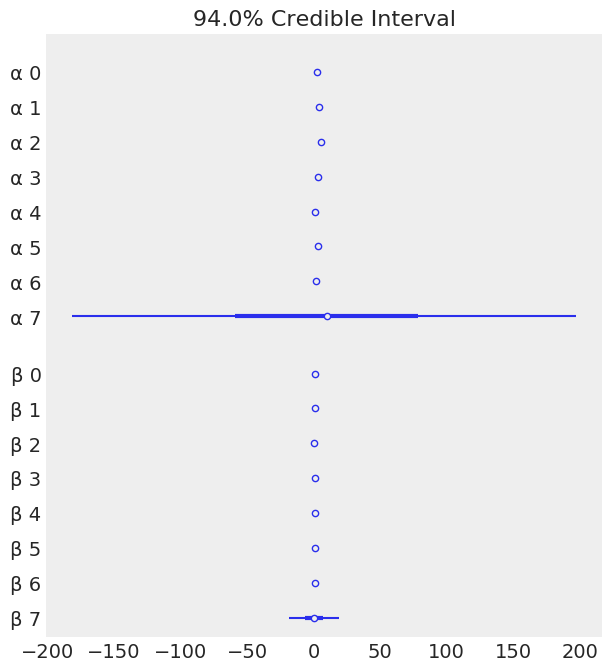

In [28]:
az.plot_forest(trace_up, var_names=['α', 'β'], combined=True)
plt.savefig('B11197_03_14.png', dpi=300)


 <img src='B11197_03_15.png' width="700">

In [29]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    trace_hm = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 450.97draws/s]
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7186526118857864, but should be close to 0.8. Try to increase the number of tuning steps.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


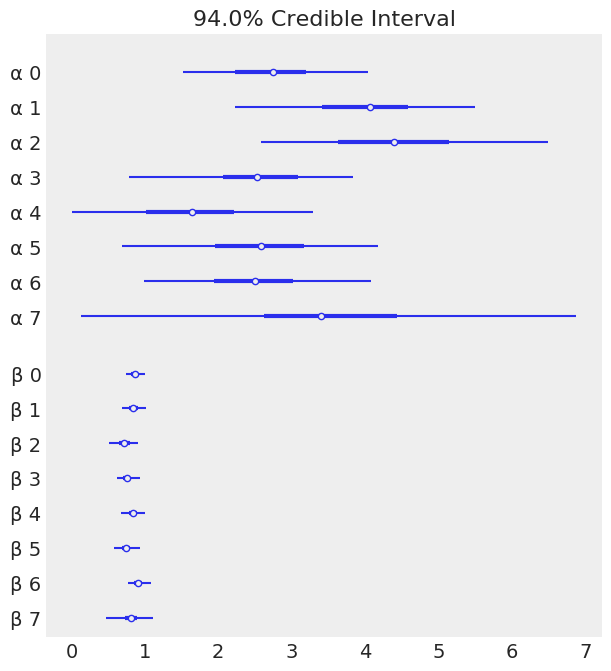

In [30]:
az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True)
plt.savefig('B11197_03_16.png', dpi=300)

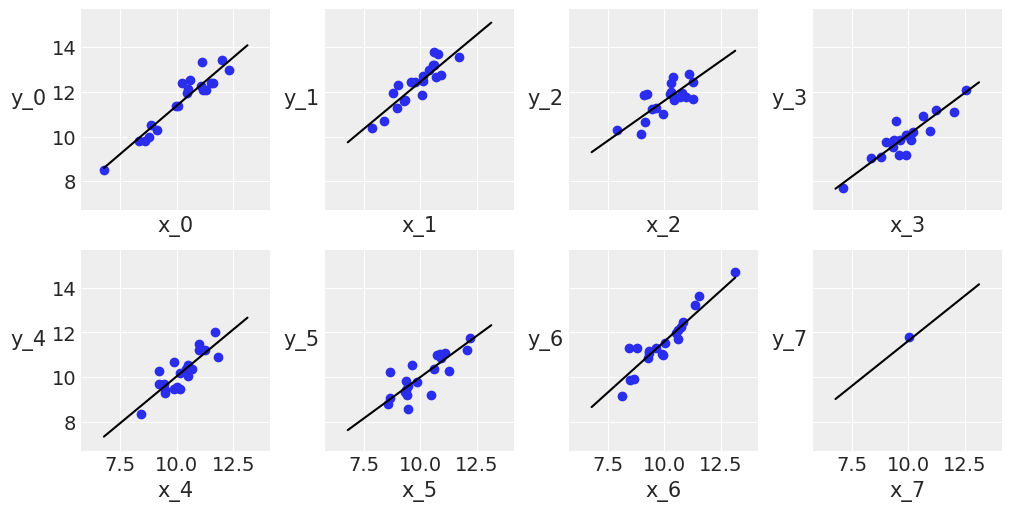

In [31]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hm['α'][:, i].mean()
    beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.savefig('B11197_03_17.png', dpi=300)

## Polynomial regression

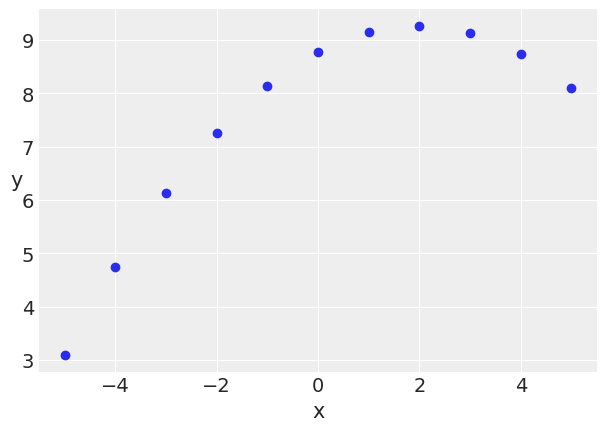

In [32]:
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_18.png', dpi=300)

In [33]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_2.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    mu = α + β1 * x_2 + β2 * x_2**2

    y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_2)

    trace_poly = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, β1, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:06<00:00, 757.07draws/s] 
The acceptance probability does not match the target. It is 0.9200935744990767, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9271833602014701, but should be close to 0.8. Try to increase the number of tuning steps.


In [34]:
#az.plot_trace(trace_poly);

In [35]:
#az.summary(trace_poly)

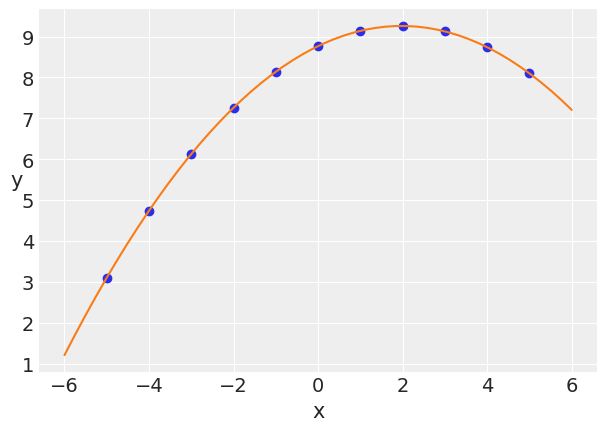

In [36]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['α'].mean() + trace_poly['β1'].mean() * \
    x_p + trace_poly['β2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')
plt.savefig('B11197_03_19.png', dpi=300)

## Multiple Linear regression

In [37]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

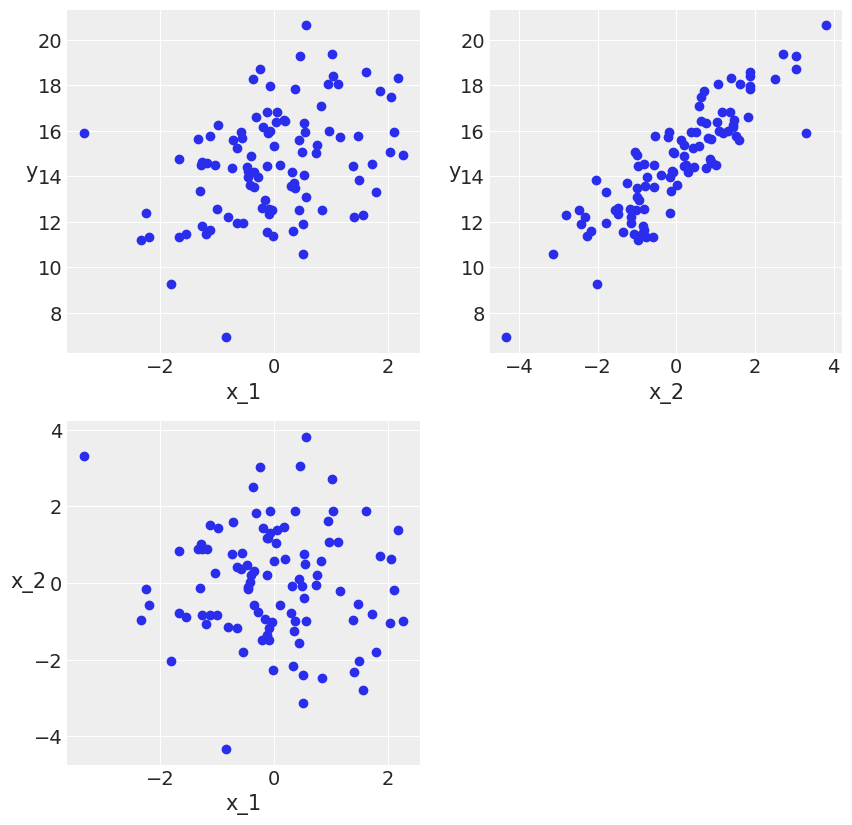

In [38]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

scatter_plot(X_centered, y)
plt.savefig('B11197_03_20.png', dpi=300)

In [39]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α_tmp + pm.math.dot(X_centered, β)

    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α_tmp]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1471.76draws/s]
The acceptance probability does not match the target. It is 0.8842132479469446, but should be close to 0.8. Try to increase the number of tuning steps.


In [40]:
varnames = ['α', 'β', 'ϵ']
#az.plot_trace(trace_mlr, var_names=varnames);

In [41]:
az.summary(trace_mlr, var_names=varnames)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α[0],1.85,0.45,0.01,1.00,2.66,4497.0,1.0
β[0],0.97,0.04,0.00,0.89,1.05,4707.0,1.0
β[1],1.47,0.03,0.00,1.41,1.53,5243.0,1.0
ϵ,0.47,0.03,0.00,0.41,0.54,3330.0,1.0


## Confounding variables and redundant variables

In [42]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

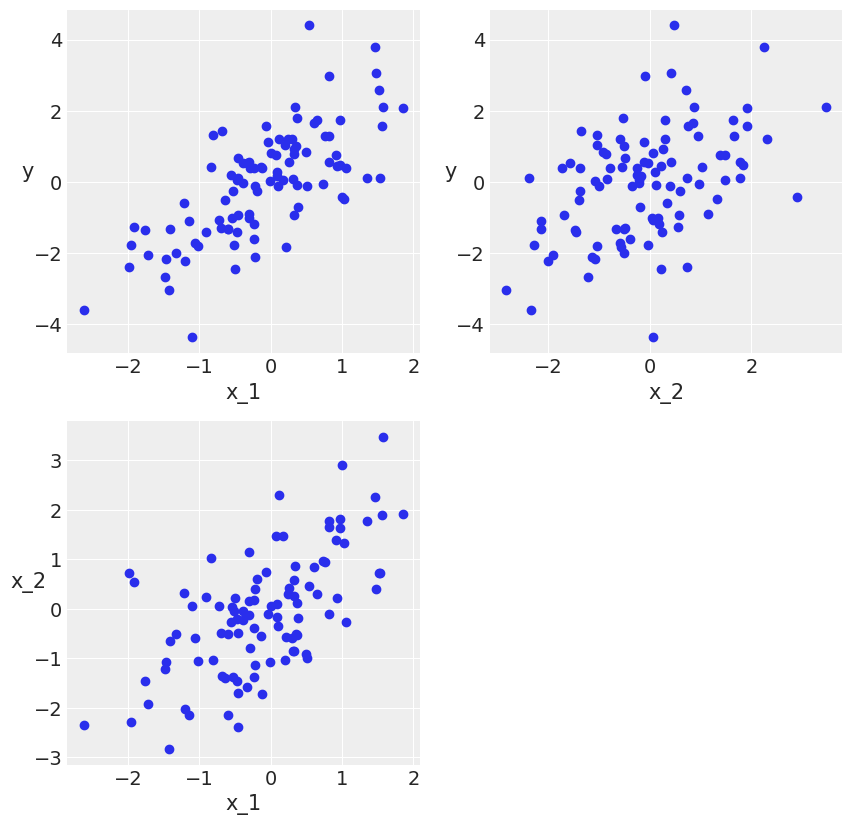

In [43]:
scatter_plot(X, y)
plt.savefig('B11197_03_21.png', dpi=300)

In [44]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1x2 = pm.sample(2000)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1 = pm.sample(2000)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, β1, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1245.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β1, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 2095.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 2347.26draws/s]


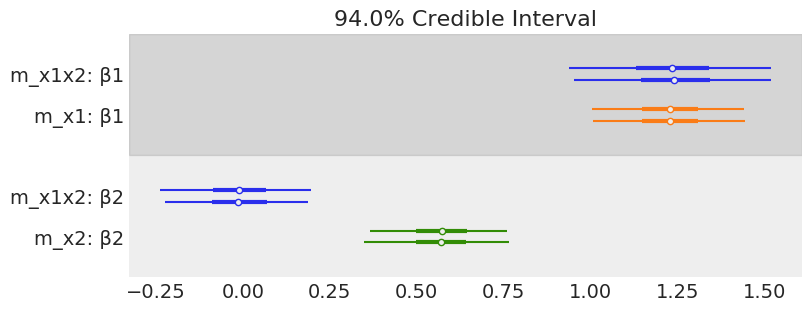

In [45]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=False, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_22.png', dpi=300)

In [46]:
# just repeating the code from a couple of cells before, but with a lower value of `scale`.
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

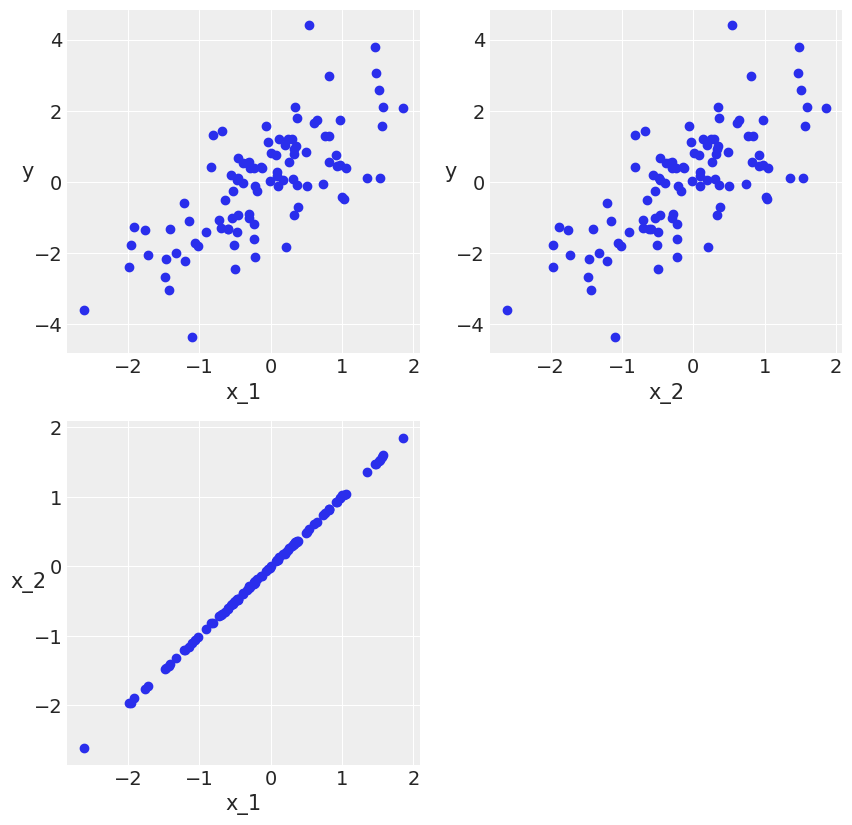

In [47]:
scatter_plot(X, y)
plt.savefig('B11197_03_23.png', dpi=300)

In [48]:
with pm.Model() as model_red:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + pm.math.dot(X, β)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_red = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:57<00:00, 86.87draws/s] 


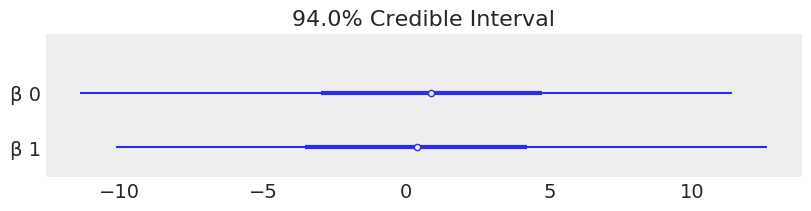

In [49]:
az.plot_forest(trace_red, var_names=['β'], combined=True, figsize=(8, 2))
plt.savefig('B11197_03_24.png', dpi=300)

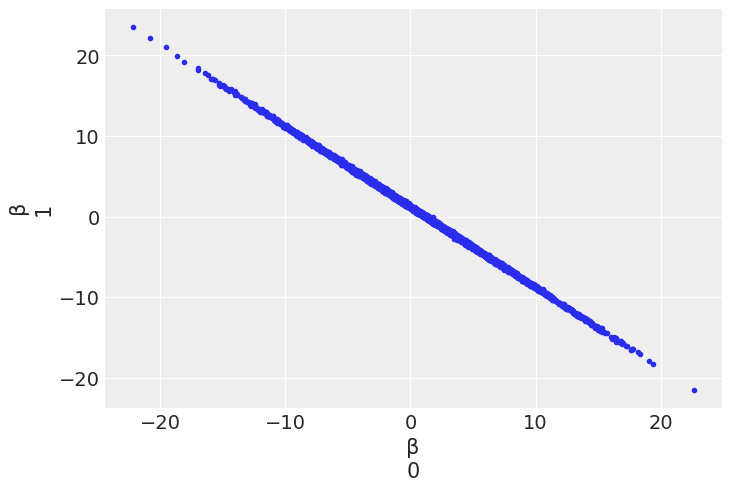

In [50]:
az.plot_pair(trace_red, var_names=['β'])
plt.savefig('B11197_03_25.png', dpi=300)

## Masking effect variables

In [51]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T

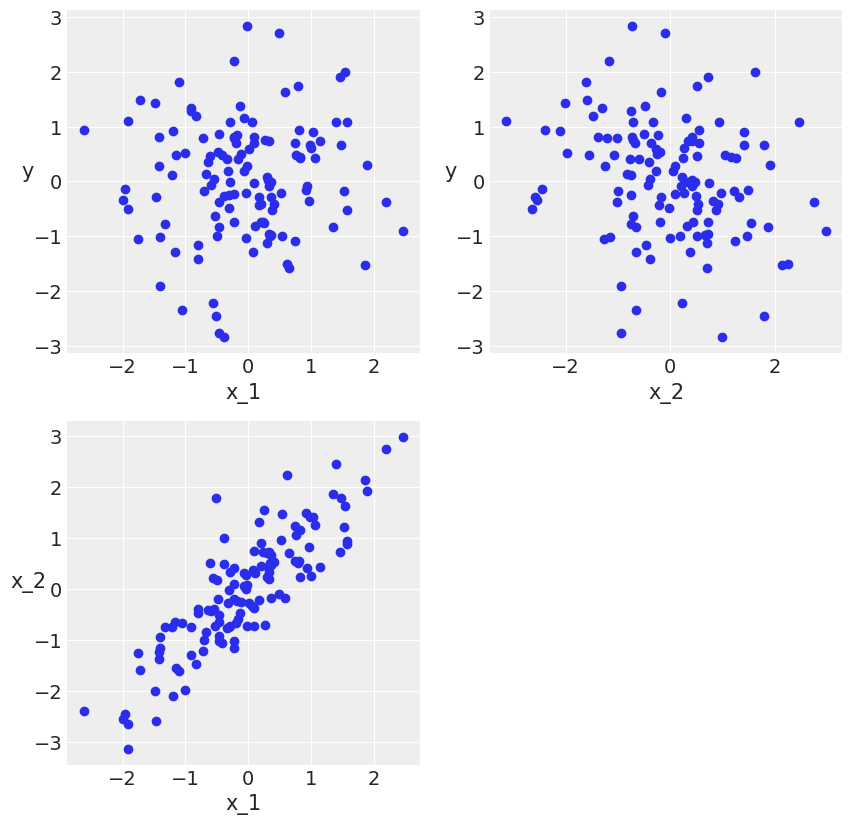

In [52]:
scatter_plot(X, y)
plt.savefig('B11197_03_26.png', dpi=300, figsize=(5.5, 5.5))

In [53]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1x2 = pm.sample(1000)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1 = pm.sample(1000)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, β1, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1322.95draws/s]
The acceptance probability does not match the target. It is 0.8799975731569054, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8794618209457493, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β1, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1637.94draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2421.14draws/s]


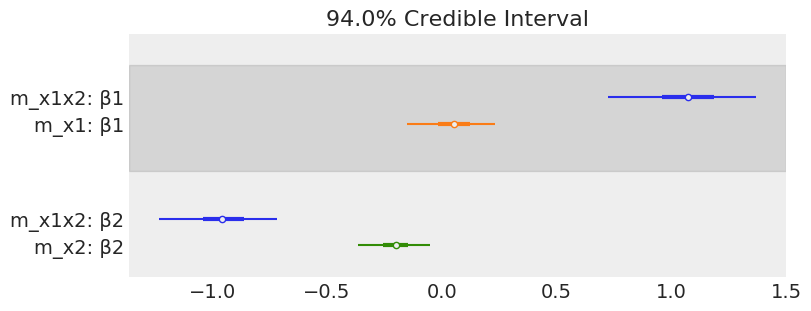

In [54]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=True, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_27.png', dpi=300, bbox_inches='tight')

## Variable variance

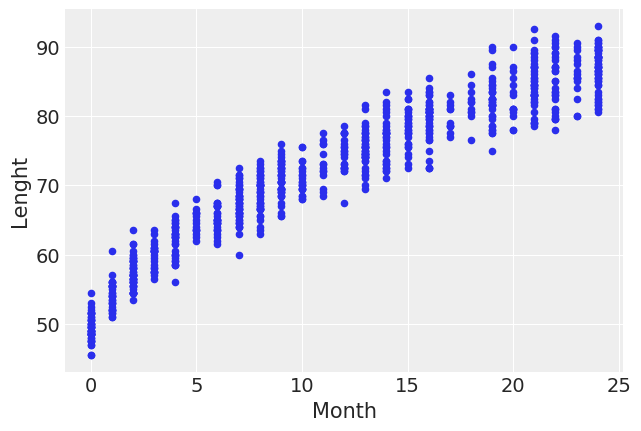

In [55]:
data = pd.read_csv('../data/babies.csv')
data.plot.scatter('Month', 'Lenght')
plt.savefig('B11197_03_28.png', dpi=300)

In [56]:
with pm.Model() as model_vv:
    α = pm.Normal('α', sd=10)
    β = pm.Normal('β', sd=10)
    γ = pm.HalfNormal('γ', sd=10)
    δ = pm.HalfNormal('δ', sd=10)

    x_shared = shared(data.Month.values * 1.)

    μ = pm.Deterministic('μ', α + β * x_shared**0.5)
    ϵ = pm.Deterministic('ϵ', γ + δ * x_shared)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=data.Lenght)

    trace_vv = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [δ, γ, β, α]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 891.33draws/s] 


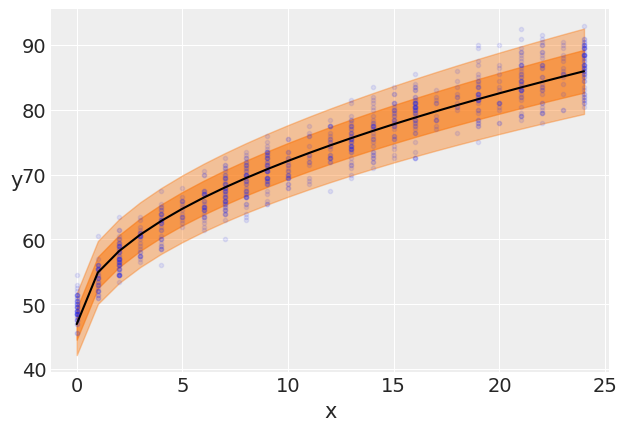

In [57]:
plt.plot(data.Month, data.Lenght, 'C0.', alpha=0.1)

μ_m = trace_vv['μ'].mean(0)
ϵ_m = trace_vv['ϵ'].mean(0)

plt.plot(data.Month, μ_m, c='k')
plt.fill_between(data.Month, μ_m + 1 * ϵ_m, μ_m -
                 1 * ϵ_m, alpha=0.6, color='C1')
plt.fill_between(data.Month, μ_m + 2 * ϵ_m, μ_m -
                 2 * ϵ_m, alpha=0.4, color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_29.png', dpi=300)

In [58]:
x_shared.set_value([0.5])
ppc = pm.sample_posterior_predictive(trace_vv, 2000, model=model_vv)
y_ppc = ppc['y_pred'][:, 0]

100%|██████████| 2000/2000 [00:01<00:00, 1526.30it/s]


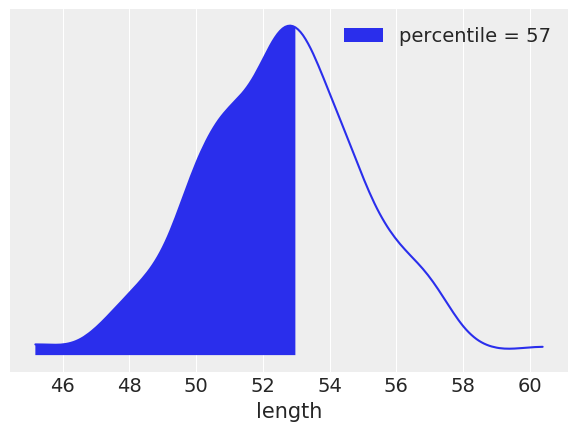

In [59]:
ref = 53
density, l, u = az._fast_kde(y_ppc)
x_ = np.linspace(l, u, 200)
plt.plot(x_, density)
percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)
plt.fill_between(x_[x_ < ref], density[x_ < ref],
                 label='percentile = {:2d}'.format(percentile))
plt.xlabel('length')
plt.yticks([])
plt.legend()
plt.savefig('B11197_03_30.png', dpi=300)

In [ ]:
x_4 = ans[ans.group == 'IV']['x'].values
y_4 = ans[ans.group == 'IV']['y'].values

with pm.Model() as model_t2:
    α = pm.Normal('α', mu=0, sd=100)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    #ν = pm.Gamma('ν', mu=20, sd=15)
    #ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_4, sd=ϵ, nu=ν, observed=y_4)
    trace_t2 = pm.sample(2000)